In [1]:
import intake
import os.path
import xarray as xr
from utils import plotter
from analogs import calculate_analogs, load_LENS_dataset, print_analog_stats, plot_analog_validation
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
import cartopy

k = 6

In [2]:
# lat, lon = 33.1072795,35.4688208
lat, lon = 20.194824,-100.9225607

In [3]:
nc_file = './data/gto_cesm.nc'
if not os.path.isfile(nc_file):
    URL = "/home/jhexr/code/clustering_analogs/data/aws-cesm1-le.json"
    if not os.path.isfile(URL):
        URL = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/\
            catalogs/aws-cesm1-le.json"
        LENS_dataset = load_LENS_dataset(URL)
        LENS_dataset.to_netcdf("./data/Lens_dataset.nc")
    else:
        LENS_dataset = xr.open_dataset('./data/Lens_dataset.nc')
    print(LENS_dataset)
    curr_analogs = calculate_analogs(
        LENS_dataset, lat, lon, 
        ['TREFHT', 'PRECC'], LENS_dataset, 
        '2000-01-01', '2009-12-31', 
        '2000-01-01', '2009-12-31')
    curr_analogs = curr_analogs.load()
    print("Done")
    print(curr_analogs)
    curr_analogs.to_netcdf('./data/gto_cesm.nc')
else:
    curr_analogs = xr.load_dataset('./data/gto_cesm.nc')

In [4]:
curr_distances = curr_analogs['Standardized Euclidean Distance'].mean(dim='member_id')
da = curr_distances
cmap = 'Greens_r'
title = 'Current Climate Analogs for 2000-2009'
vmin = 0
vmax = 3
location=(lon,lat)
mask_out_ocean = True
cbar_ylabel=None

In [5]:
# mask ocean
if mask_out_ocean:
    import xesmf as xe
    ds_in = xr.open_dataset("./data/lsmask.oisst.v2.nc")
    regridder = xe.Regridder(ds_in, da, 'nearest_s2d', reuse_weights=True)
    ds_in = regridder(ds_in).squeeze()
    da.values[ds_in['lsmask'] == 1] = np.nan

Reuse existing file: nearest_s2d_720x1440_192x288.nc
using dimensions ('lat', 'lon') from data variable lsmask as the horizontal dimensions for this dataset.


In [6]:
da_min = da.where(da != da.sel(lat=lat, lon=lon, method='nearest'))

df = da_min.to_dataframe().dropna()
df.reset_index(inplace=True)
print(df)

             lat     lon  Standardized Euclidean Distance
0     -90.000000    0.00                        36.365845
1     -90.000000    1.25                        36.285984
2     -90.000000    2.50                        36.281197
3     -90.000000    3.75                        36.278149
4     -90.000000    5.00                        36.366158
...          ...     ...                              ...
18473  83.403145  327.50                        23.556850
18474  83.403145  328.75                        23.543150
18475  83.403145  330.00                        23.494827
18476  83.403145  331.25                        23.432343
18477  83.403145  332.50                        23.290562

[18478 rows x 3 columns]


In [7]:
df['inverse_sed'] = 1/df['Standardized Euclidean Distance']

In [8]:
import pandas as pd
from sklearn import preprocessing

x = df[['inverse_sed']].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['inverse_sed'] = pd.DataFrame(x_scaled)
print(df)


             lat     lon  Standardized Euclidean Distance  inverse_sed
0     -90.000000    0.00                        36.365845     0.007321
1     -90.000000    1.25                        36.285984     0.007346
2     -90.000000    2.50                        36.281197     0.007347
3     -90.000000    3.75                        36.278149     0.007348
4     -90.000000    5.00                        36.366158     0.007321
...          ...     ...                              ...          ...
18473  83.403145  327.50                        23.556850     0.013396
18474  83.403145  328.75                        23.543150     0.013406
18475  83.403145  330.00                        23.494827     0.013442
18476  83.403145  331.25                        23.432343     0.013488
18477  83.403145  332.50                        23.290562     0.013593

[18478 rows x 4 columns]


In [9]:
quan = 0.9
print(df['inverse_sed'].quantile(quan))

0.053574320301413486


In [10]:
df.loc[df['inverse_sed'] < df['inverse_sed'].quantile(quan), 'inverse_sed'] = np.nan
print(df)
df = df.dropna()
df = df.drop(columns=['Standardized Euclidean Distance'])
print(df)

             lat     lon  Standardized Euclidean Distance  inverse_sed
0     -90.000000    0.00                        36.365845          NaN
1     -90.000000    1.25                        36.285984          NaN
2     -90.000000    2.50                        36.281197          NaN
3     -90.000000    3.75                        36.278149          NaN
4     -90.000000    5.00                        36.366158          NaN
...          ...     ...                              ...          ...
18473  83.403145  327.50                        23.556850          NaN
18474  83.403145  328.75                        23.543150          NaN
18475  83.403145  330.00                        23.494827          NaN
18476  83.403145  331.25                        23.432343          NaN
18477  83.403145  332.50                        23.290562          NaN

[18478 rows x 4 columns]
             lat     lon  inverse_sed
5656  -44.764397  293.75     0.054319
5676  -42.879581  295.00     0.060434
5687  -4

             lat     lon  inverse_sed
5656  -44.764397  293.75     0.054319
5676  -42.879581  295.00     0.060434
5687  -41.937172  293.75     0.054456
5698  -40.994766  293.75     0.055547
5699  -40.994766  296.25     0.064500
...          ...     ...          ...
12936  46.649216   41.25     0.054085
12938  46.649216   43.75     0.053785
12939  46.649216   45.00     0.054974
12940  46.649216   46.25     0.054739
12942  46.649216   48.75     0.053676

[1848 rows x 3 columns]


Text(0, 0.5, 'Lat')

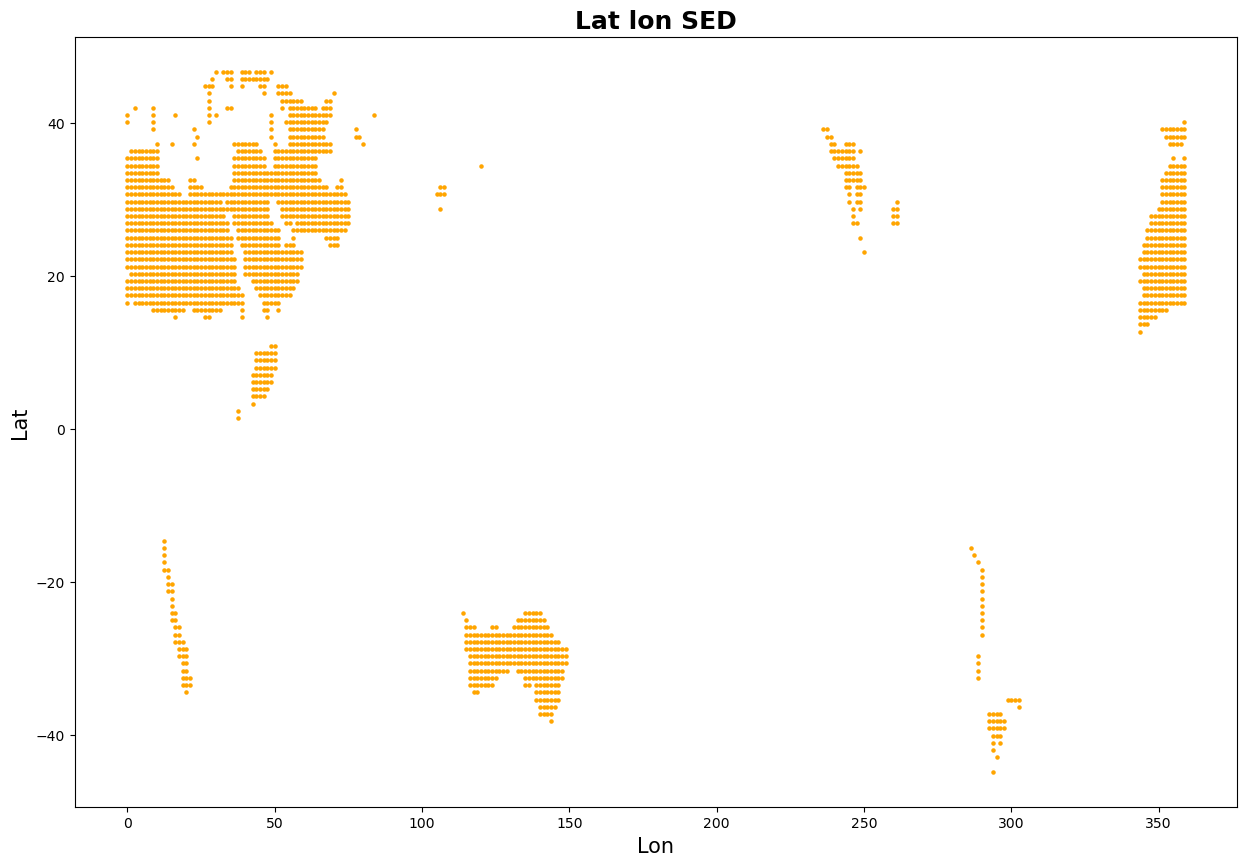

In [11]:
print(df)
from sklearn.cluster import KMeans
plt.style.use('default')
x=np.array(df['lon'])
y=np.array(df['lat'])
plt.figure(figsize=(15, 10))
plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
plt.title('Lat lon SED',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)

In [12]:
from sklearn.cluster import KMeans
X = np.array(df.drop(['inverse_sed'], 1).astype(float))
Y = np.array(df['inverse_sed'].astype(float))
print(X)

[[-44.76439667 293.75      ]
 [-42.87958145 295.        ]
 [-41.93717194 293.75      ]
 ...
 [ 46.6492157   45.        ]
 [ 46.6492157   46.25      ]
 [ 46.6492157   48.75      ]]


In [13]:
kmeans = KMeans(n_clusters=k, random_state=0,max_iter=1000)
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)

centers = wt_kmeansclus.cluster_centers_
print(centers)

[[-29.59855374 132.6318726 ]
 [ 22.10973649 352.46871127]
 [ 20.42028639  15.13342405]
 [ 31.77414684 246.54544323]
 [ 25.95990227  50.85934949]
 [-32.32524773 293.11178657]]


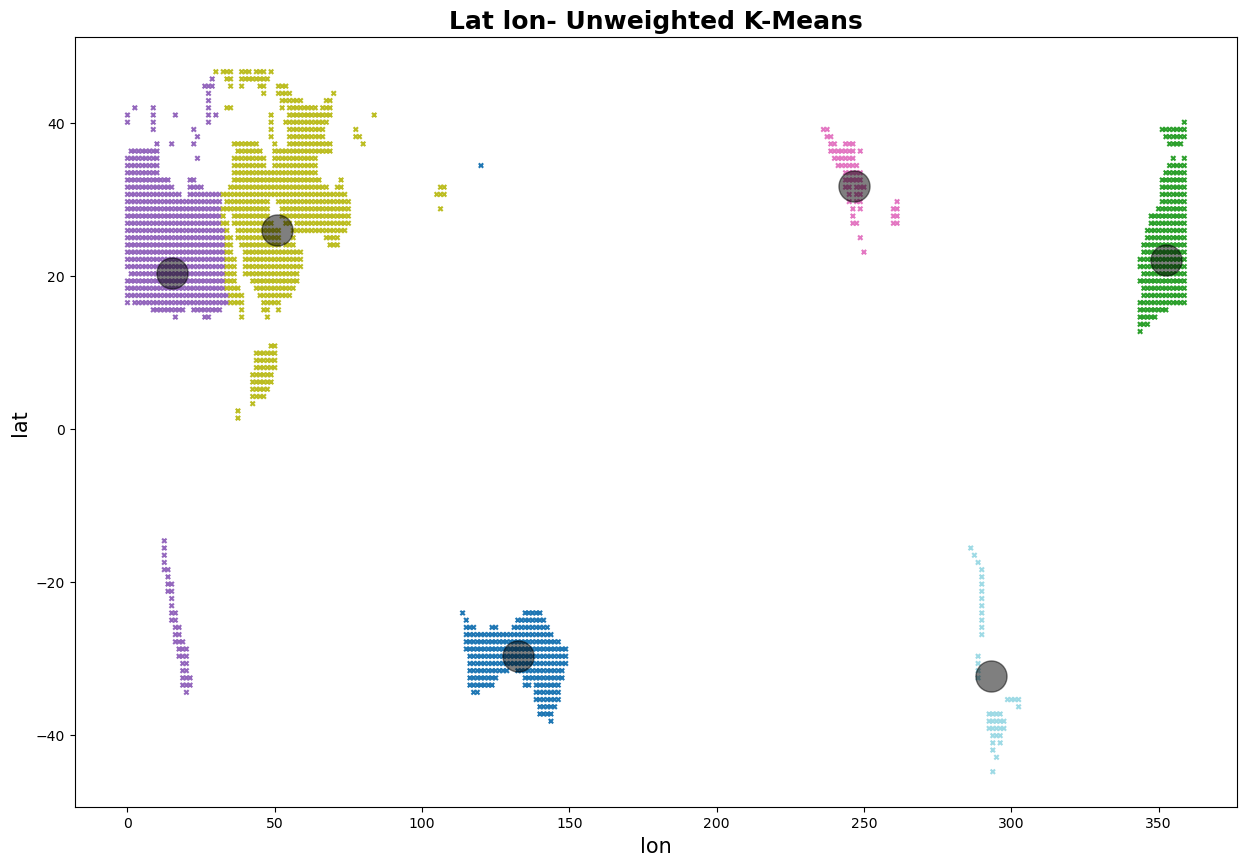

In [14]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 1], X[:, 0], c=wt_kmeansclus.labels_.astype(float), s=10, cmap='tab20',marker ='x')
plt.title('Lat lon- Unweighted K-Means',fontsize=18, fontweight='bold')
plt.xlabel('lon',fontsize=15)
plt.ylabel('lat',fontsize=15)

plt.scatter(centers[:, 1], centers[:, 0], c='black', s=500, alpha=0.5)

In [15]:
top_k=[(p[1], p[0]) for p in centers]
print(top_k)

[(132.63187259872996, -29.598553740789416), (352.4687112734457, 22.109736486038948), (15.133424049004006, 20.420286391189745), (246.54544322705934, 31.77414683979679), (50.85934949318333, 25.959902266196842), (293.1117865714229, -32.32524772541794)]


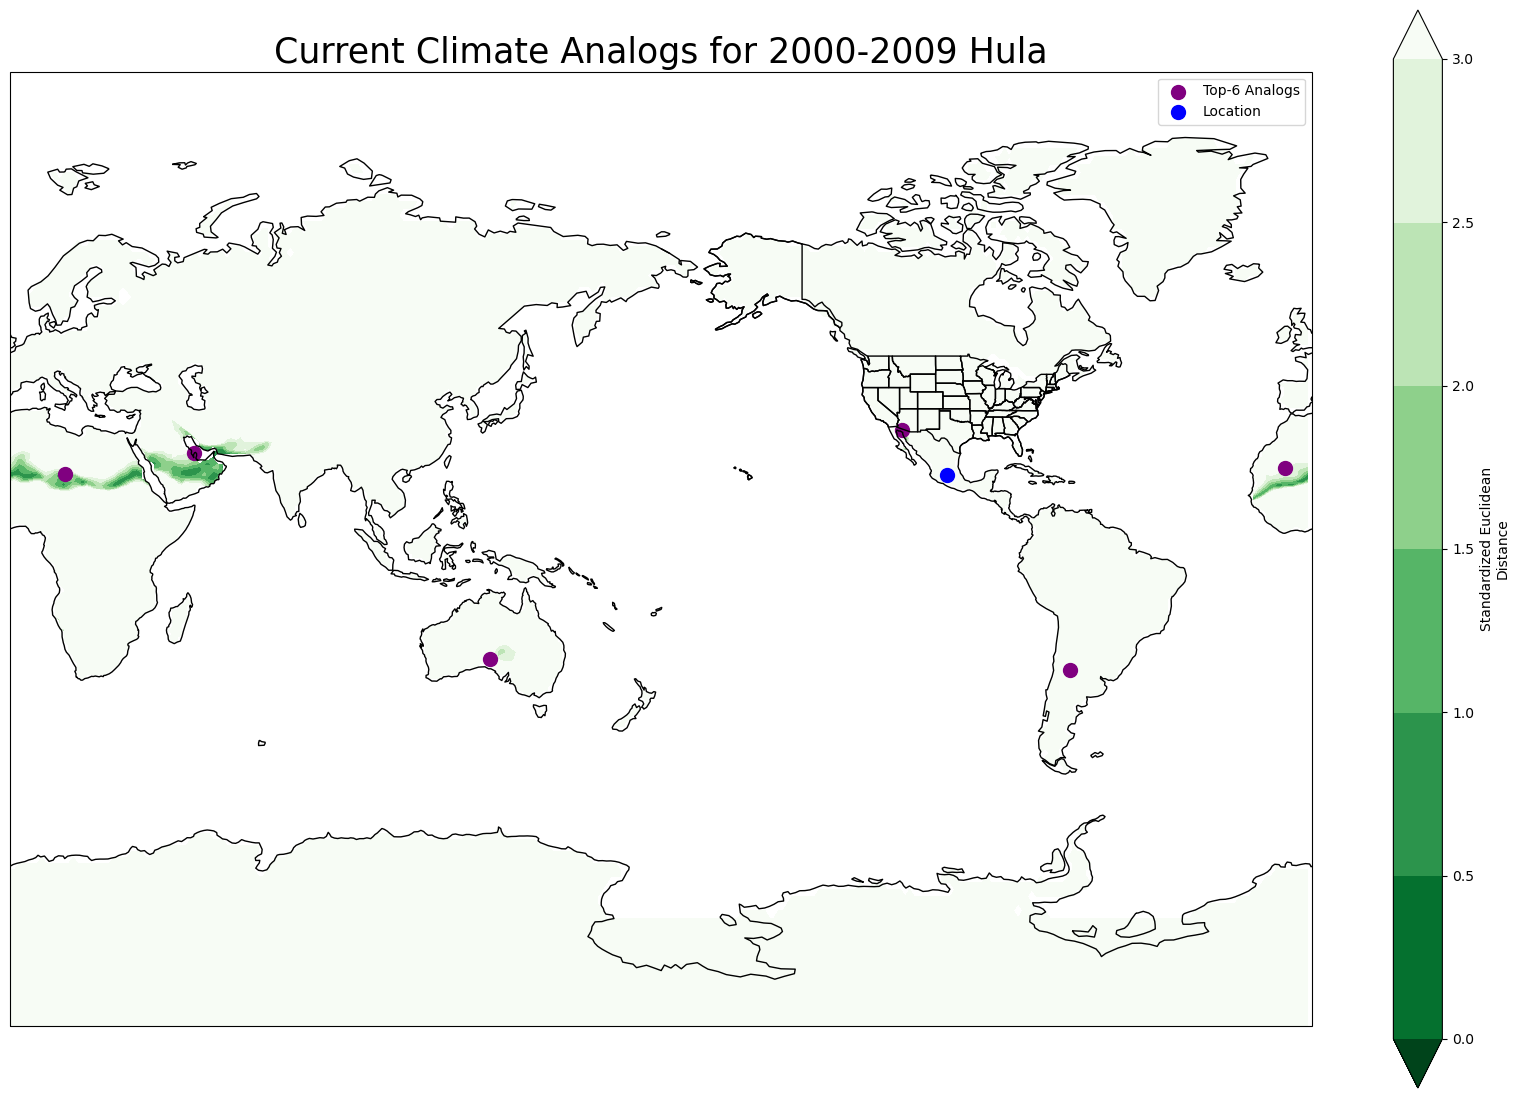

In [16]:
# plot
plt.figure(figsize=(21,14))
ax = plt.axes(projection=ccrs.Miller(central_longitude=180))
contours = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
if cbar_ylabel:
    contours.colorbar.ax.set_ylabel(cbar_ylabel)
plt.title(title, size=25)
ax.set_global(); ax.coastlines(); ax.add_feature(cartopy.feature.STATES)

#plot points
if top_k:  
    ax.scatter([a[0] for a in top_k],[a[1] for a in top_k],
        transform=ccrs.PlateCarree(), color='purple',
        s=100, label = "Top-{} Analogs".format(k))
ax.scatter(*(location), transform=ccrs.PlateCarree(),
    color='blue', s=100, label="Location")
ax.legend()
plt.show()